<h1 style="text-align:center;"> LSTM for Stock Market Prediction</h1>
<h2 style="text-align:center;"> Facebook</h2>

<p style="font-size:18px;color:gray;"> <strong>Step 1:</strong> For this Predictive model we will utilize some modules that are necessary to obtain, create and visualize this predictive model such as <span class="py-modules">sqlalchemy</span>, <span class="py-modules">NumPy</span>, <span class="py-modules">Pandas</span>, <span class="py-modules">SciKitlearn</span>, <span class="py-modules">MatPlotLib</span>, and <span class="py-modules">Keras</span>.</p>

In [1]:
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt
import requests
from sqlalchemy import create_engine
from config import password

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 2:</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;"> Now, we start building our model by first defining the dataset that the model will train on. We're using datasets from NASDAQ provided by <a href="https://finance.yahoo.com/">https://finance.yahoo.com/</a>. For this example were using <span style="color:blue;">Facebook (FB)</span> historical data.

 <p style="font-size:18px;color:gray;"> After pulling the data from our SQL database we read it using the the csv built-in function included in the Pandas library.</p>

In [2]:
# Connecting to Database
connection_string = f"ofygklqv:{password}@batyr.db.elephantsql.com:5432/ofygklqv"
engine = create_engine(f'postgresql://{connection_string}', pool_size=2, pool_recycle=1200, connect_args={'connect_timeout': 10},
client_encoding="utf8", pool_pre_ping=True)

In [3]:
ticker = "FB"
df = pd.read_sql_query('select * from ticker', con=engine)
id = df[df['symbol']==ticker]['stock_id'].values[0] # returning ID for the specified ticker(symbol)
df = pd.read_sql_query(f'select * from stock WHERE stock_id = {id}', con=engine)
print(df.shape)
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d")
df.index = df['date']
df = df[["close"]]

(1258, 7)


#### Sort date and close
<p style="font-size:14px;color:gray;"> Since the dates and values are in descending order we need to reverse the dataframe</p>

In [4]:
df = df.iloc[::-1]
df

,close
date,
2016-07-06,116.699997
2016-07-07,115.849998
2016-07-08,117.239998
2016-07-11,117.870003
2016-07-12,117.930000
...,...
2021-06-28,355.640015
2021-06-29,351.890015
2021-06-30,347.709991


<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 3: Plotting the close prices</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">We will plot the close prices using "Close" values as our dependent variable and Date as our independent variable (this is time scale).</p>

Text(0, 0.5, 'Close Price USD')

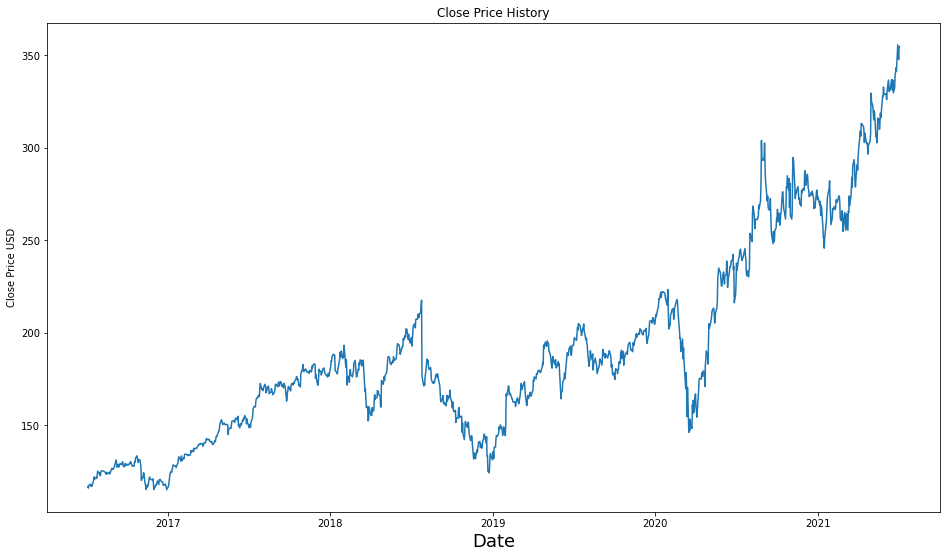

In [5]:
plt.figure(figsize=(16,9))
plt.title("Close Price History")
plt.plot(df['close'])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD")

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 4: Splitting the data into Training/Test sets </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">Once the data has been cleaned and filtered, we need to split the data into train and test data, since our model doesn't utilize more than one variable, we can't use train_test_split found in <span class="py-modules">sklearn</span> libray. We will use a 80-20 ratio for the splitting process.</p>

In [6]:
# Create New DataFrame with close values
data = df
# Convert Dataframe to Numpy array
dataset = data.values

In [7]:
#Get number of row to train our module
training_data_len = math.ceil(len(dataset) * 0.80)
training_data_len

1007

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00685811],
       [0.00332514],
       [0.0091026 ],
       ...,
       [0.96703927],
       [0.99480444],
       [0.99609293]])

In [9]:
# Create training Dataset
#create the scaled Training Data Set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.00685811, 0.00332514, 0.0091026 , 0.01172118, 0.01197056,
       0.00719064, 0.00931044, 0.00752316, 0.01795586, 0.02310984,
       0.02855478, 0.02310984, 0.02473086, 0.02734941, 0.02564528,
       0.03445693, 0.04135665, 0.03695082, 0.03848869, 0.03341782,
       0.0310071 , 0.03869653, 0.04198012, 0.04243734, 0.04160603,
       0.04085786, 0.04094101, 0.04085786, 0.03678456, 0.0342907 ,
       0.0387381 , 0.03682614, 0.03537135, 0.03782368, 0.0387381 ,
       0.03503886, 0.03674299, 0.04119039, 0.04775758, 0.04484805,
       0.04601188, 0.04621969, 0.0476329 , 0.06101663, 0.06650318,
       0.06326115, 0.05008519, 0.05669396, 0.0505424 , 0.05287   ,
       0.05528078, 0.05827343, 0.05652766, 0.05648612, 0.06188952,
       0.06247142, 0.05365973, 0.05095804, 0.05669396, 0.05893841])]
[0.05420006092352986]



In [10]:
# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
samples,time_steps = x_train.shape
print(samples,time_steps)

947 60


In [12]:
# Reshaping the data
x_train = np.reshape((x_train),(samples,time_steps,1))
x_train.shape

(947, 60, 1)

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 5: LSTM build</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">At this point our dataset is clean and scaled, this allows us to build the LSTM model that is going to process and predict the values. The two main parameters used are  optimizer=<span style="color:green;">'adam'</span> and loss=<span style="color:green;">'mean_squared_error'</span>; which are found in the <span class="py-modules">LSTM</span> module</p>

In [13]:
# Building the LSTM Model
model = Sequential()
# Creating Layers
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compiling the model
# Loss function is used to measure how well the model did on training.
model.compile(optimizer='adam', loss='mean_squared_error')

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 6: Training our Model
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">It's time to train our model, this requires a x_train and y_train datasets, among other parameters. To see the meaning of these parameters please visit tensorflow's official website <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM">https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM</a> </p>

In [15]:
#training the Model
# Batch size is the total number of training examples present in a single batch
# Epoch is the iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=2,verbose=5)

Epoch 1/2
Epoch 2/2


In [16]:
# creating the Testing dataset 
# Array that contained scaled values test_data = scaled_data[training_data_len - 60:through the end, all columns]

test_data = scaled_data[training_data_len-60: , :]
# Creating testing datasets 
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  


In [17]:
# Converting data to a numpy Array
x_test = np.array(x_test)


In [18]:
# Reshaping the data, because LST model is expecting a 3 dimensional array
# x_test.shape[0] represents the number of Rows, 
#  x_test.shape[1] represents the number of time steps
# 3rd element in the dimensional array (1) represents the close price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 7: Make/Perform the Predictions
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">To make our predictions we need make use of our x_test dataset, it's important to mention that this numpy array must be a three dimensional array(see description in cell above)</p>

In [19]:
# Get the models predicted price values
# This step "unscale" the values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 8: Model Evaluation
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">For the model evaluation we'll utilize RMSE as our main indicator</p>

In [20]:
# Evaluating our model, Getting the root mean error (RMSE), Model accuracy 
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

12.795291429496856

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 9: Plotting trained, tested and predicted datasets.
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">During this step we will use our training data, test data and predictions to easily visualize the accuracy of our model. Our training data represents the 80% of the original data set, and the teste data the rest; our predicted values has the same length as our test data but this data has been already processed by our model</p>

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

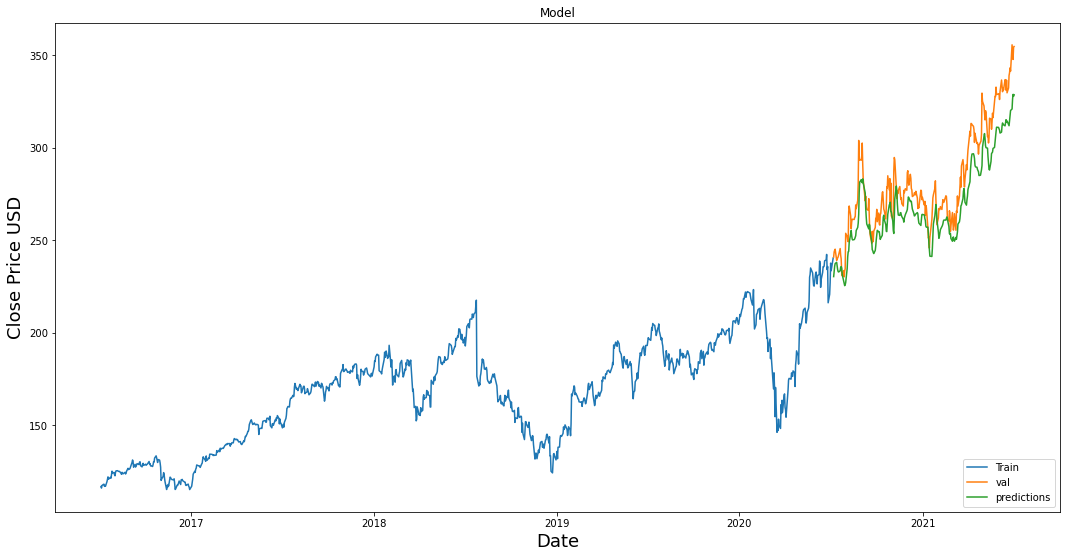

In [22]:
# Visualize the models data
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD", fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','predictions']])
plt.legend(['Train','val','predictions'], loc='lower right')
plt.show()

In [23]:
# show the Valid(actual prices) and the predicted prices
valid

,close,predictions
date,,
2020-07-07,240.860001,230.247787
2020-07-08,243.580002,233.391739
2020-07-09,244.500000,235.836670
2020-07-10,245.070007,237.314789
2020-07-13,239.000000,237.983337
...,...,...
2021-06-28,355.640015,320.917023
2021-06-29,351.890015,326.237396
2021-06-30,347.709991,328.803986


#### Storing predicted values in our Database

In [24]:
valid['stock_id'] = id
valid.reset_index(drop=True,inplace=True)
valid.to_sql(name='predicted', con=engine, if_exists='append', index=False)

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 10: Saving Model(h5).
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">Finally that we have verified our model accuracy and performance we can save it.</p>

In [25]:
# Saving Model
model.save("facebook_model.h5")

<p style="font-size:22px;color:black;text-align:center"> <strong style="line-height: 0px;">Conclusion
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">LSTM can be applied to predict future stock values on different markets. Even though this model can be very accurate, this doesn't mean it can be used by itself to make decisions, this must be use in conjuntion with risk analysis, financial analysis and market evaluation. Please do not use this models as definitive tool to predict the market! </p>